In [1]:
import logging
import sys
from pathlib import Path

# Project path setup
project_root = Path.cwd()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Enable INFO logging so we can see score_pairs diagnostics
logging.basicConfig(level=logging.INFO, format="%(name)s | %(levelname)s | %(message)s")

print(f"Project root: {project_root}")

Project root: i:\Winter-Break-Research


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pairs_trading_etf.cointegration.engle_granger import run_engle_granger
from pairs_trading_etf.features.pair_generation import enumerate_pairs

# Load raw prices
PRICE_PATH = project_root / "data" / "raw" / "etf_prices.csv"
prices = pd.read_csv(PRICE_PATH, index_col=0, parse_dates=True)
print(f"Loaded prices: {prices.shape[0]} rows x {prices.shape[1]} tickers")
prices.columns = [c.upper() for c in prices.columns]
prices.head()

numexpr.utils | INFO | NumExpr defaulting to 12 threads.


Loaded prices: 2768 rows x 50 tickers


,XLK,IYW,XLF,VFH,XLE,XLY,XLV,XLI,XLP,XLB,...,SPLV,VEA,VWO,VGK,EWJ,FXI,EWW,ILF,AGG,BND
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,30.534763,20.073277,14.189484,34.705315,55.728378,58.185120,45.555286,41.595539,31.120232,36.220402,...,25.346596,28.823038,28.524836,38.932407,39.503231,27.940067,50.209694,21.636505,77.678307,57.295559
2014-01-03,30.388075,19.983847,14.287391,34.893730,55.523952,58.027668,45.662689,41.708530,31.061590,36.133476,...,25.362089,28.830069,28.488909,38.939186,39.734829,27.593836,50.186913,21.648596,77.707512,57.302715
2014-01-06,30.336327,19.958616,14.300440,34.932964,55.600643,57.669029,45.472649,41.466373,30.944283,35.935989,...,25.284660,28.773802,28.215870,38.973007,39.602486,27.104578,49.647751,21.521679,77.809631,57.352745
2014-01-07,30.612408,20.153551,14.306969,34.995773,56.022167,58.018921,45.951912,41.724682,31.112898,35.872803,...,25.470472,28.942598,28.330833,39.236843,39.767910,27.112103,50.202103,21.551899,77.846123,57.424255
2014-01-08,30.612408,20.171892,14.352654,35.066422,55.632568,57.861485,46.356796,41.652039,30.878313,36.086082,...,25.362089,28.935572,28.280540,39.216549,39.834087,27.435766,49.495884,21.322235,77.612671,57.238319


In [3]:
# Enumerate all unordered ticker pairs
all_pairs = enumerate_pairs(prices.columns.tolist())
print(f"Total unique pairs: {len(all_pairs)}")

# Sample 100 pairs for quick diagnostics
random.seed(42)
sample_pairs = random.sample(all_pairs, min(100, len(all_pairs)))
print(f"Sampled {len(sample_pairs)} pairs for analysis")

Total unique pairs: 1225
Sampled 100 pairs for analysis


In [4]:
# Run Engle-Granger on the sample with use_log=True (default)
results = []
for leg_x, leg_y in sample_pairs:
    try:
        eg = run_engle_granger(prices[leg_x], prices[leg_y], use_log=True)
        results.append({
            "leg_x": leg_x,
            "leg_y": leg_y,
            "pvalue": eg.pvalue,
            "tstat": eg.test_statistic,
            "hedge_ratio": eg.hedge_ratio,
            "half_life": eg.half_life,
        })
    except ValueError as e:
        results.append({"leg_x": leg_x, "leg_y": leg_y, "pvalue": None, "error": str(e)})

results_df = pd.DataFrame(results)
results_df.head(10)

,leg_x,leg_y,pvalue,tstat,hedge_ratio,half_life
0,XLE,VGK,0.755009,-1.515992,0.850735,3698.177968
1,IYW,XLE,0.850755,-1.226754,0.817981,NaN
2,XLC,SMH,0.629134,-1.801210,0.414627,NaN
3,QQQ,VGT,0.078533,-3.150884,0.886754,NaN
4,SPY,TLT,0.991222,0.330358,0.478326,NaN
5,XLV,XLC,0.657186,-1.742547,0.722791,NaN
6,XLE,HYG,0.781029,-1.446780,0.790219,3973.522939
7,IVV,EWW,0.952300,-0.644529,0.626833,NaN
8,VFH,IWD,0.319659,-2.411009,1.216751,32465.054221
9,VGK,BND,0.696561,-1.656281,1.510540,19580.286667


In [5]:
# Summary statistics
valid = results_df.dropna(subset=["pvalue"])
print(f"Valid EG tests: {len(valid)} / {len(results_df)}")
print(f"p-value <=0.05: {(valid['pvalue'] <= 0.05).sum()}")
print(f"p-value <=0.10: {(valid['pvalue'] <= 0.10).sum()}")
print(valid['pvalue'].describe())

Valid EG tests: 100 / 100
p-value <=0.05: 15
p-value <=0.10: 22
count    100.000000
mean       0.444448
std        0.346807
min        0.000207
25%        0.119183
50%        0.361717
75%        0.793588
max        0.991222
Name: pvalue, dtype: float64


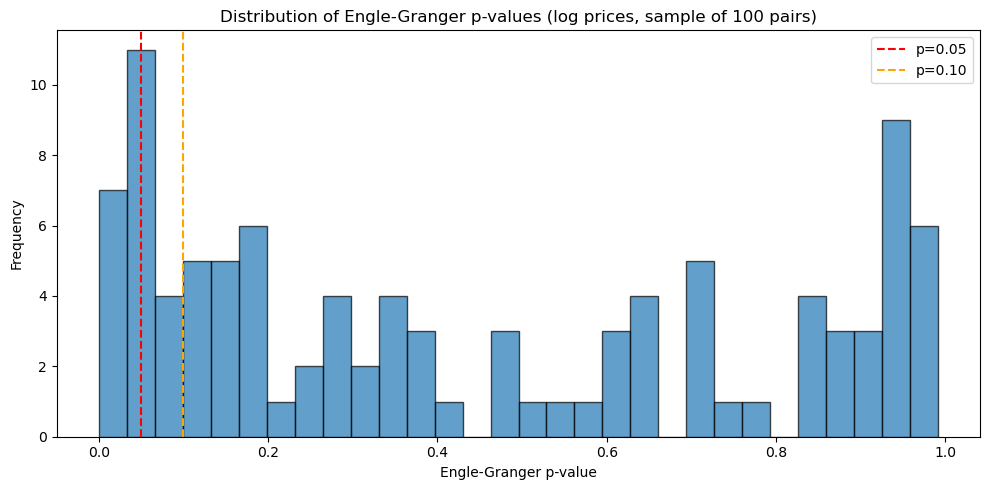

In [6]:
# Plot histogram of p-values
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(valid['pvalue'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(0.05, color='red', linestyle='--', label='p=0.05')
ax.axvline(0.10, color='orange', linestyle='--', label='p=0.10')
ax.set_xlabel('Engle-Granger p-value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Engle-Granger p-values (log prices, sample of 100 pairs)')
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
# Show pairs with p <= 0.10
significant = valid[valid['pvalue'] <= 0.10].sort_values('pvalue')
print(f"Pairs with p <= 0.10:")
significant

Pairs with p <= 0.10:


,leg_x,leg_y,pvalue,tstat,hedge_ratio,half_life
24,XLC,HYG,0.000207,-4.945609,3.240076,NaN
22,HYG,EWJ,0.002958,-4.259552,0.646429,NaN
89,XLU,VGT,0.004853,-4.117173,0.435415,NaN
61,XLU,IWF,0.015882,-3.747927,0.556232,74473.648605
86,XLU,VOO,0.015961,-3.746272,0.691742,78.160558
11,IYW,SMH,0.024288,-3.603079,0.810119,9726.752227
57,XLI,SOXX,0.032286,-3.501237,0.448103,NaN
93,IBB,AGG,0.033817,-3.484258,2.011831,28474.113388
63,XLI,SCHV,0.035591,-3.465370,1.194976,102878.245628
76,XLU,MDY,0.036275,-3.458301,0.893573,8254.699666


In [8]:
# Compare log vs level: run the same pairs without log transform
results_levels = []
for leg_x, leg_y in sample_pairs:
    try:
        eg = run_engle_granger(prices[leg_x], prices[leg_y], use_log=False)
        results_levels.append({"leg_x": leg_x, "leg_y": leg_y, "pvalue_levels": eg.pvalue})
    except ValueError:
        results_levels.append({"leg_x": leg_x, "leg_y": leg_y, "pvalue_levels": None})

levels_df = pd.DataFrame(results_levels)
comparison = results_df[["leg_x", "leg_y", "pvalue"]].merge(levels_df, on=["leg_x", "leg_y"])
comparison = comparison.rename(columns={"pvalue": "pvalue_log"})
comparison.dropna().head(10)

,leg_x,leg_y,pvalue_log,pvalue_levels
0,XLE,VGK,0.755009,0.751435
1,IYW,XLE,0.850755,0.913027
2,XLC,SMH,0.629134,0.647125
3,QQQ,VGT,0.078533,0.034106
4,SPY,TLT,0.991222,1.000000
5,XLV,XLC,0.657186,0.773327
6,XLE,HYG,0.781029,0.804930
7,IVV,EWW,0.952300,0.987305
8,VFH,IWD,0.319659,0.749999
9,VGK,BND,0.696561,0.788857


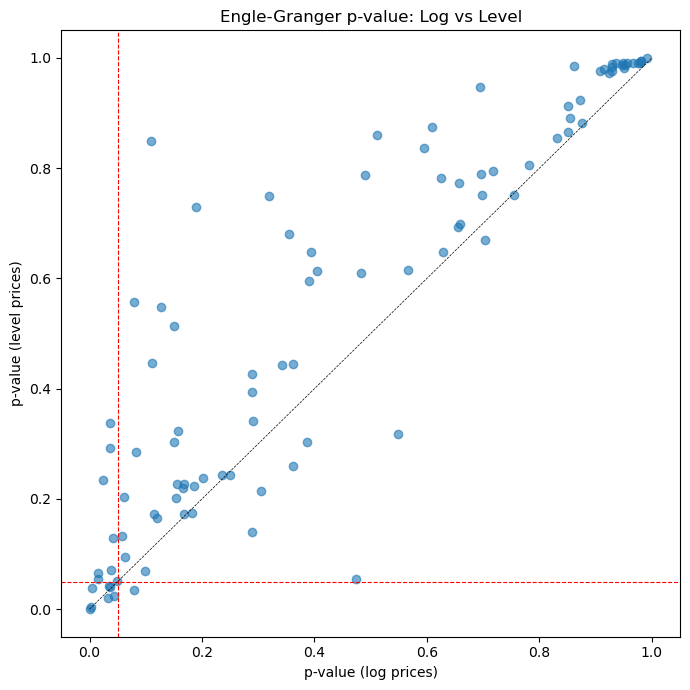

In [9]:
# Scatter: log vs level p-values
comp_valid = comparison.dropna()
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(comp_valid['pvalue_log'], comp_valid['pvalue_levels'], alpha=0.6)
ax.axhline(0.05, color='red', linestyle='--', lw=0.8)
ax.axvline(0.05, color='red', linestyle='--', lw=0.8)
ax.set_xlabel('p-value (log prices)')
ax.set_ylabel('p-value (level prices)')
ax.set_title('Engle-Granger p-value: Log vs Level')
ax.plot([0, 1], [0, 1], 'k--', lw=0.5)
plt.tight_layout()
plt.show()